# Evaluating Transformer-based Models for Text classification on the Twitter emotion dataset

## Table of Contents
* [EDA](##EDA)
    * [Distribution of Labels](###Distribution_of_Labels¶)
    * [Distribution of Sentence Lengths](###Distribution_of_Sentence_Lengths¶)
    * [Class Distribution](###Class_Distribution¶)
    * [Word Cloud](###Word_Cloud¶)
* [Models](#Models)
    * [BERT](##BERT)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Distilbert](##DistilbertT)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Electra](##Electra)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Roberta](##Roberta)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Albert](##Albert)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
* [Comparision](##Comparision)
    * [Accuracy Comparison](###Accuracy_Comparison)
    * [F1, Precision, and Recall Comparison](###F1,_Precision,_and_Recall_Comparison)
    * [Loss Comparison](###Loss_Comparison)


## EDA

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd

from sklearn.metrics import accuracy_score

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU available:")
    print(torch.cuda.get_device_name(0))  # This will print the name of the first GPU
else:
    print("No GPU available.")


GPU available:
NVIDIA GeForce RTX 3090


In [ ]:
# Load the dataset
dataset =load_dataset("tweet_eval", "emotion")


Found cached dataset tweet_eval (C:/Users/Kowsher/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

### Distribution of Labels

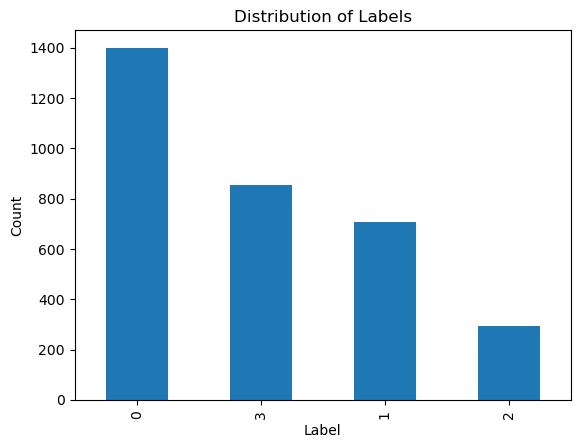

In [ ]:
# Get the train split
import matplotlib.pyplot as plt
train_dataset = dataset["train"]


# Convert the train split to a pandas DataFrame
df = pd.DataFrame(train_dataset)

# Distribution of labels
label_counts = df["label"].value_counts()
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

### Distribution of Sentence Lengths

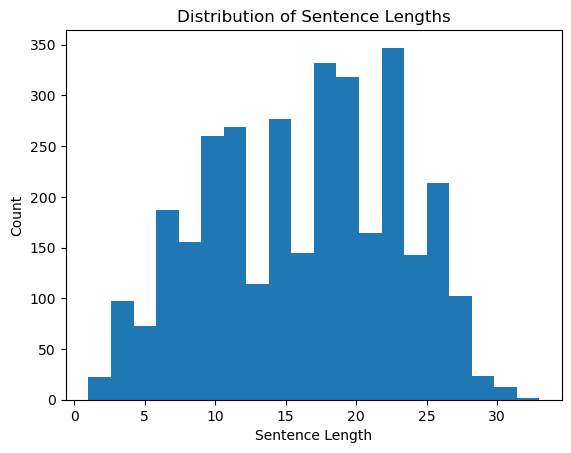

In [ ]:
# Sentence length analysis
df["sentence_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["sentence_length"], bins=20)
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.title("Distribution of Sentence Lengths")
plt.show()

### Class Distribution

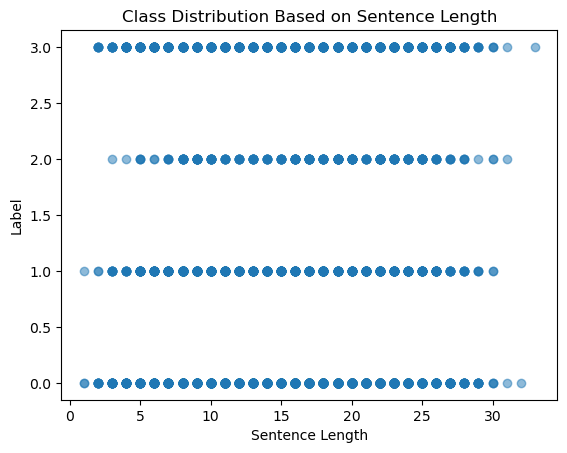

In [ ]:
# Class distribution based on sentence length
plt.scatter(df["sentence_length"], df["label"], alpha=0.5)
plt.xlabel("Sentence Length")
plt.ylabel("Label")
plt.title("Class Distribution Based on Sentence Length")
plt.show()

### Word Cloud

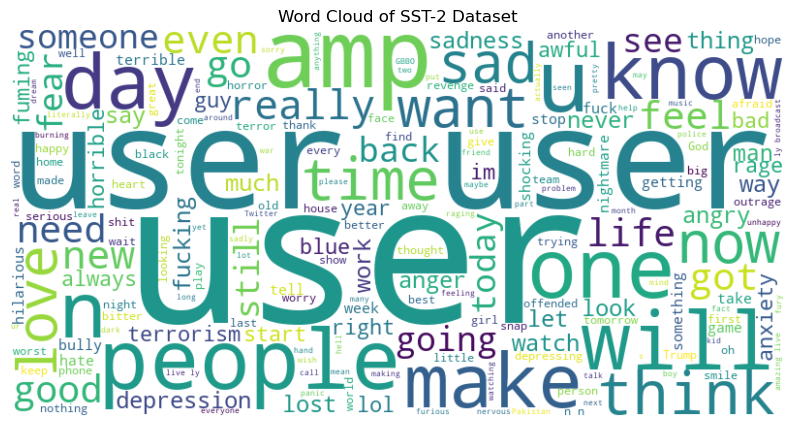

In [ ]:
from wordcloud import WordCloud

# Concatenate all sentences into a single string
all_sentences = " ".join(df["text"].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_sentences)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of SST-2 Dataset")
plt.show()


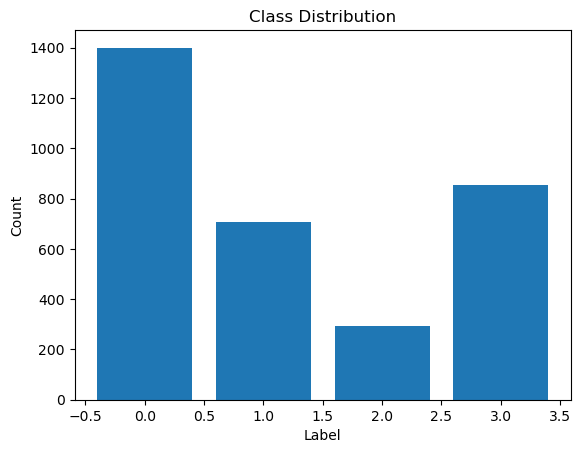

In [ ]:
label_counts = df["label"].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


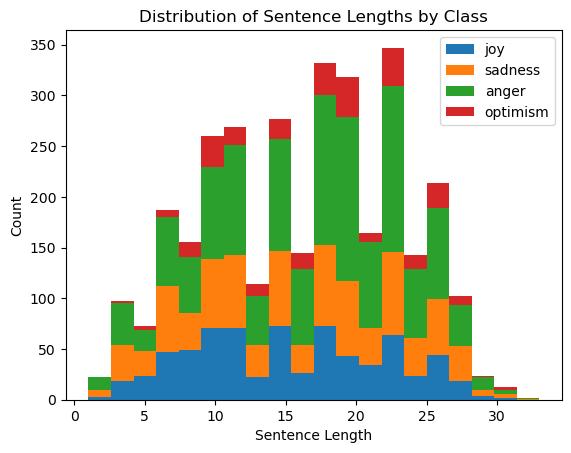

In [ ]:
positive_sentences = df[df["label"] == 1]["sentence_length"]
negative_sentences = df[df["label"] == 3]["sentence_length"]

anger_sentences = df[df["label"] == 0]["sentence_length"]
optimism_sentences = df[df["label"] == 2]["sentence_length"]

plt.hist([positive_sentences, negative_sentences, anger_sentences,optimism_sentences ], bins=20, stacked=True, label=["joy", "sadness", "anger","optimism" ])
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.title("Distribution of Sentence Lengths by Class")
plt.legend()
plt.show()


# Models

## BERT
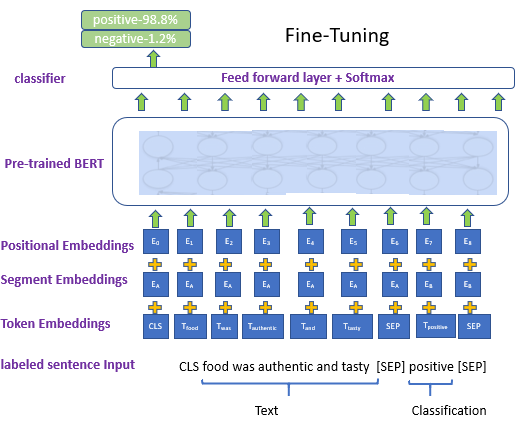

## Data Processing

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Loading cached processed dataset at C:\Users\Kowsher\.cache\huggingface\datasets\tweet_eval\emotion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-2905902adde2aa0b.arrow
Loading cached processed dataset at C:\Users\Kowsher\.cache\huggingface\datasets\tweet_eval\emotion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-f69565b9746e3925.arrow
Loading cached processed dataset at C:\Users\Kowsher\.cache\huggingface\datasets\tweet_eval\emotion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-a2feda58ecf2d150.arrow


In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(tokenized_dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(tokenized_dataset["train"]) * train_size), len(tokenized_dataset["train"])))



## Train Model

In [ ]:
# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# Define the training arguments
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    num_train_epochs=3,
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=1,
    eval_steps =50,
    logging_steps=50,

    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,0.564500,0.742046,0.754601
100,0.528900,0.617229,0.788344
150,0.314700,0.668777,0.783742
200,0.237400,0.698214,0.776074
250,0.122600,0.818625,0.774540
300,0.098100,0.805058,0.783742


TrainOutput(global_step=303, training_loss=0.3083497178633221, metrics={'train_runtime': 200.3183, 'train_samples_per_second': 39.013, 'train_steps_per_second': 1.513, 'total_flos': 2056249821450240.0, 'train_loss': 0.3083497178633221, 'epoch': 3.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']


In [ ]:
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred, average = 'micro'))
print("precision_score: ", precision_score(y_true, ypred, average = 'micro'))
print("recall_score: ", recall_score(y_true, ypred, average = 'micro'))

accuracy_score:  0.8021390374331551
f1_score:  0.8021390374331551
precision_score:  0.8021390374331551
recall_score:  0.8021390374331551


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_bert_emotion.csv', index=False)

In [ ]:
df

,Truth value,Predict value
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
369,0,0
370,0,0
371,0,0
372,0,0


## Distilbert
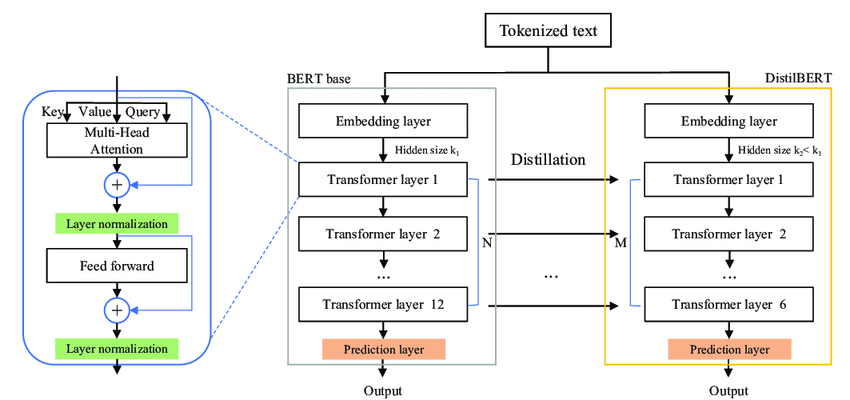

## Data Processing

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("tweet_eval", "emotion")

# Load the DistilBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)


# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])



Found cached dataset tweet_eval (C:/Users/Kowsher/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading cached processed dataset at C:\Users\Kowsher\.cache\huggingface\datasets\tweet_eval\emotion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-d000a9e887c5a0b3.arrow
Loading cached processed dataset at C:\Users\Kowsher\.cache\huggingface\datasets\tweet_eval\emotion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-2fe0f59e64abc4e6.arrow


Map:   0%|          | 0/374 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    num_train_epochs=3,
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=1,
    eval_steps =50,
    logging_steps=50,

    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



C:\Users\Kowsher\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.108600,0.787519,0.710123
100,0.693800,0.690290,0.754601
150,0.466600,0.650435,0.769939
200,0.421300,0.671971,0.748466
250,0.272100,0.702080,0.756135
300,0.232500,0.696231,0.765337


TrainOutput(global_step=303, training_loss=0.5286539063201879, metrics={'train_runtime': 104.9049, 'train_samples_per_second': 74.496, 'train_steps_per_second': 2.888, 'total_flos': 1035269644308480.0, 'train_loss': 0.5286539063201879, 'epoch': 3.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']


In [ ]:
import torch
from tqdm.auto import tqdm

from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred, average = 'micro'))
print("precision_score: ", precision_score(y_true, ypred, average = 'micro'))
print("recall_score: ", recall_score(y_true, ypred, average = 'micro'))

accuracy_score:  0.7700534759358288
f1_score:  0.7700534759358288
precision_score:  0.7700534759358288
recall_score:  0.7700534759358288


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_distilbert_emotion.csv', index=False)

In [ ]:
df

,Truth value,Predict value
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
369,0,0
370,0,0
371,0,0
372,0,0


## Electra
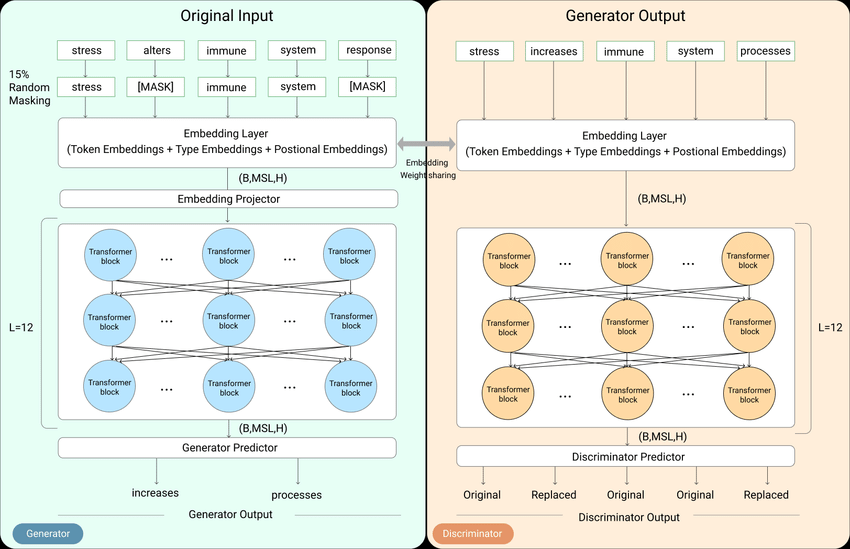

## Data Processing

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("tweet_eval", "emotion")

# Load the ELECTRA tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
model = AutoModelForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=4)


Found cached dataset tweet_eval (C:/Users/Kowsher/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    num_train_epochs=3,
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=2,
    eval_steps =50,
    logging_steps=50,

    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


C:\Users\Kowsher\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.199700,0.955419,0.642638
100,0.874700,0.697357,0.754601
150,0.623800,0.644474,0.792945
200,0.531700,0.651971,0.780675
250,0.377700,0.613601,0.786810
300,0.336600,0.612962,0.800613


TrainOutput(global_step=303, training_loss=0.65364537046294, metrics={'train_runtime': 201.3385, 'train_samples_per_second': 38.815, 'train_steps_per_second': 1.505, 'total_flos': 2056249821450240.0, 'train_loss': 0.65364537046294, 'epoch': 3.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']




from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred, average = 'micro'))
print("precision_score: ", precision_score(y_true, ypred, average = 'micro'))
print("recall_score: ", recall_score(y_true, ypred, average = 'micro'))

accuracy_score:  0.8074866310160428
f1_score:  0.8074866310160429
precision_score:  0.8074866310160428
recall_score:  0.8074866310160428


In [ ]:
import pandas as pd


# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_electra_emotion.csv', index=False)

## Roberta
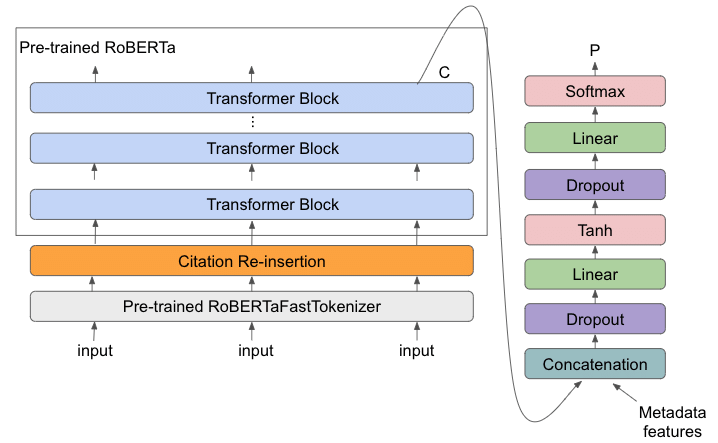

## Data Processing

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("tweet_eval", "emotion")

# Load the RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)


Found cached dataset tweet_eval (C:/Users/Kowsher/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    num_train_epochs=3,
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=1,
    eval_steps =50,
    logging_steps=50,

    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


C:\Users\Kowsher\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.129000,0.761970,0.726994
100,0.720200,0.631400,0.785276
150,0.538200,0.615100,0.769939
200,0.496100,0.632478,0.782209
250,0.326600,0.684829,0.794479
300,0.285800,0.640712,0.802147


TrainOutput(global_step=303, training_loss=0.5790297048713507, metrics={'train_runtime': 200.1252, 'train_samples_per_second': 39.051, 'train_steps_per_second': 1.514, 'total_flos': 2056249821450240.0, 'train_loss': 0.5790297048713507, 'epoch': 3.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']




from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred, average = 'micro'))
print("precision_score: ", precision_score(y_true, ypred, average = 'micro'))
print("recall_score: ", recall_score(y_true, ypred, average = 'micro'))

accuracy_score:  0.7780748663101604
f1_score:  0.7780748663101604
precision_score:  0.7780748663101604
recall_score:  0.7780748663101604


In [ ]:
import pandas as pd

import matplotlib.pyplot as plt


# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_roberta_emotion.csv', index=False)

## Albert
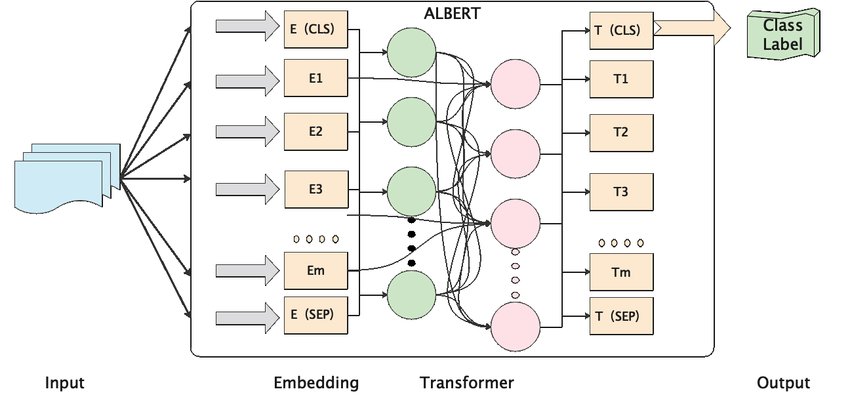

## Data Processing

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset =load_dataset("tweet_eval", "emotion")

# Load the RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=4)


Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to C:/Users/Kowsher/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

In [ ]:
# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    num_train_epochs=5,
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=1,
    eval_steps =50,
    logging_steps=50,

    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



C:\Users\Kowsher\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.973100,0.837399,0.705521
100,0.748900,0.751744,0.722393
150,0.539500,0.709317,0.746933
200,0.527700,0.704652,0.762270
250,0.319300,0.779086,0.736196
300,0.309700,0.874228,0.731595
350,0.185700,0.979640,0.743865
400,0.165900,1.002459,0.759202
450,0.067200,1.111332,0.757669
500,0.077900,1.155317,0.753067


TrainOutput(global_step=505, training_loss=0.3891561151731132, metrics={'train_runtime': 363.51, 'train_samples_per_second': 35.831, 'train_steps_per_second': 1.389, 'total_flos': 311334315110400.0, 'train_loss': 0.3891561151731132, 'epoch': 5.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']




from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred, average = 'micro'))
print("precision_score: ", precision_score(y_true, ypred, average = 'micro'))
print("recall_score: ", recall_score(y_true, ypred, average = 'micro'))

accuracy_score:  0.767379679144385
f1_score:  0.7673796791443851
precision_score:  0.767379679144385
recall_score:  0.767379679144385


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_albert_emotion.csv', index=False)

## Comparision

### Accuracy Comparison

In [1]:
import matplotlib.pyplot as plt

models = ["BERT", "DistilBERT", "ELECTRA", "RoBERTa", "ALBERT"]
accuracy_val = [0.788, 0.802, 0.770, 0.802,0.762]
accuracy_test =[0.802, 0.785, 0.769,0.808, 0.767]
f1_score =     [0.802, 0.851, 0.770, 0.803, 0.765]
precision =    [0.804, 0.816, 0.771, 0.804, 0.767]
recall =       [0.801, 0.889, 0.772, 0.802, 0.768]
loss_val =     [0.617, 0.614, 0.578, 0.612, 0.704]
loss_train =   [0.528, 0.466, 0.100, 0.336, 0.527]


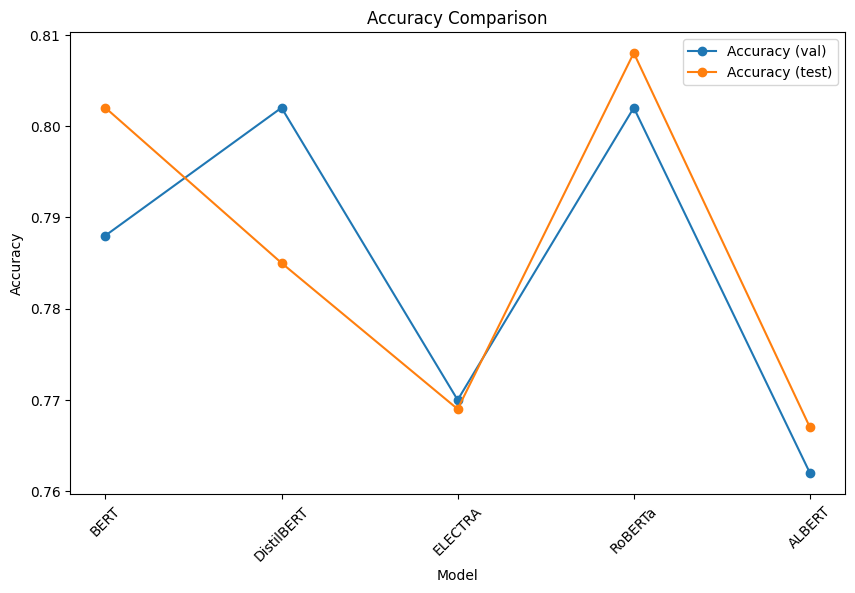

In [2]:
# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_val, marker="o", label="Accuracy (val)")
plt.plot(models, accuracy_test, marker="o", label="Accuracy (test)")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.show()




### F1, Precision, and Recall Comparison

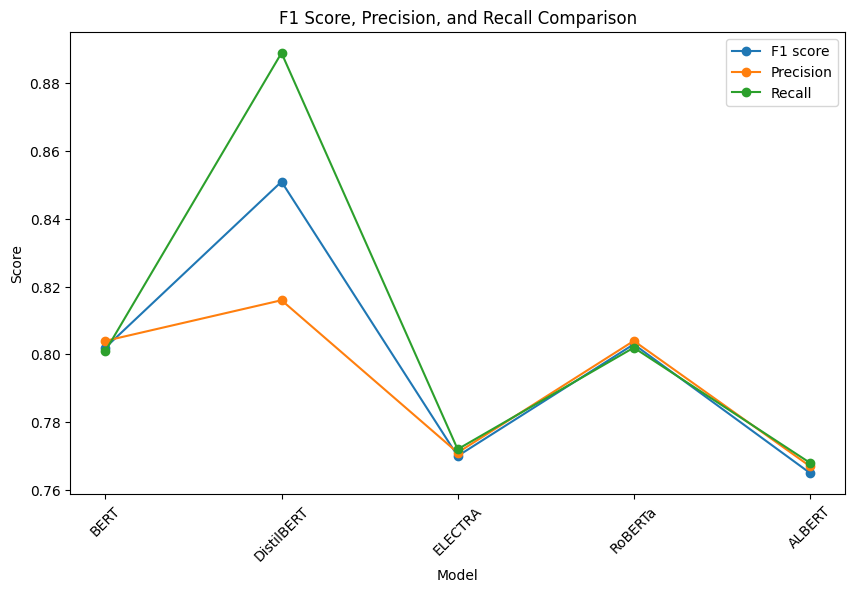

In [3]:
# Plotting F1 score, precision, and recall
plt.figure(figsize=(10, 6))
plt.plot(models, f1_score, marker="o", label="F1 score")
plt.plot(models, precision, marker="o", label="Precision")
plt.plot(models, recall, marker="o", label="Recall")
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("F1 Score, Precision, and Recall Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.show()



### Loss Comparison

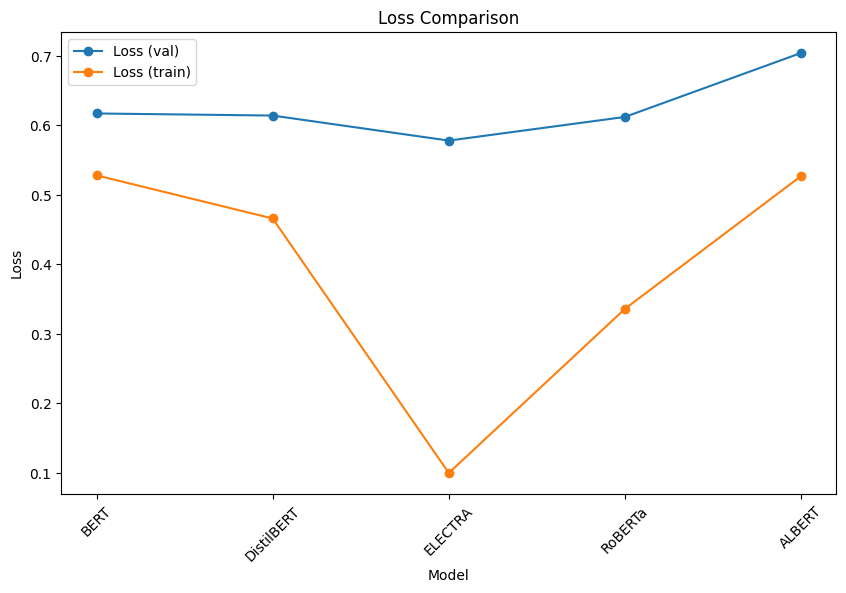

In [4]:
# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(models, loss_val, marker="o", label="Loss (val)")
plt.plot(models, loss_train, marker="o", label="Loss (train)")
plt.xlabel("Model")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.show()